In [87]:
from data_utils import *
from model_utils import *
from train_utils import *
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [88]:
# Load dataset
classes = get_classes()
# Load flattened dataset (n, 63) to match feedforward model input
dataset = load_dataset_normalized(HAND_LANDMARKS_JSON, as_sequence=False, augment=False)

# Split into train / validation
train_dataset, val_dataset = split_dataset(dataset, val_ratio=0.2, random_seed=42)

# Create DataLoaders
train_loader, val_loader = get_loaders(train_dataset, val_dataset, batch_size=32)

print(f"Aantal classes: {len(classes)}")
print(f"Classes: {classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Aantal classes: 26
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Training samples: 2084
Validation samples: 521


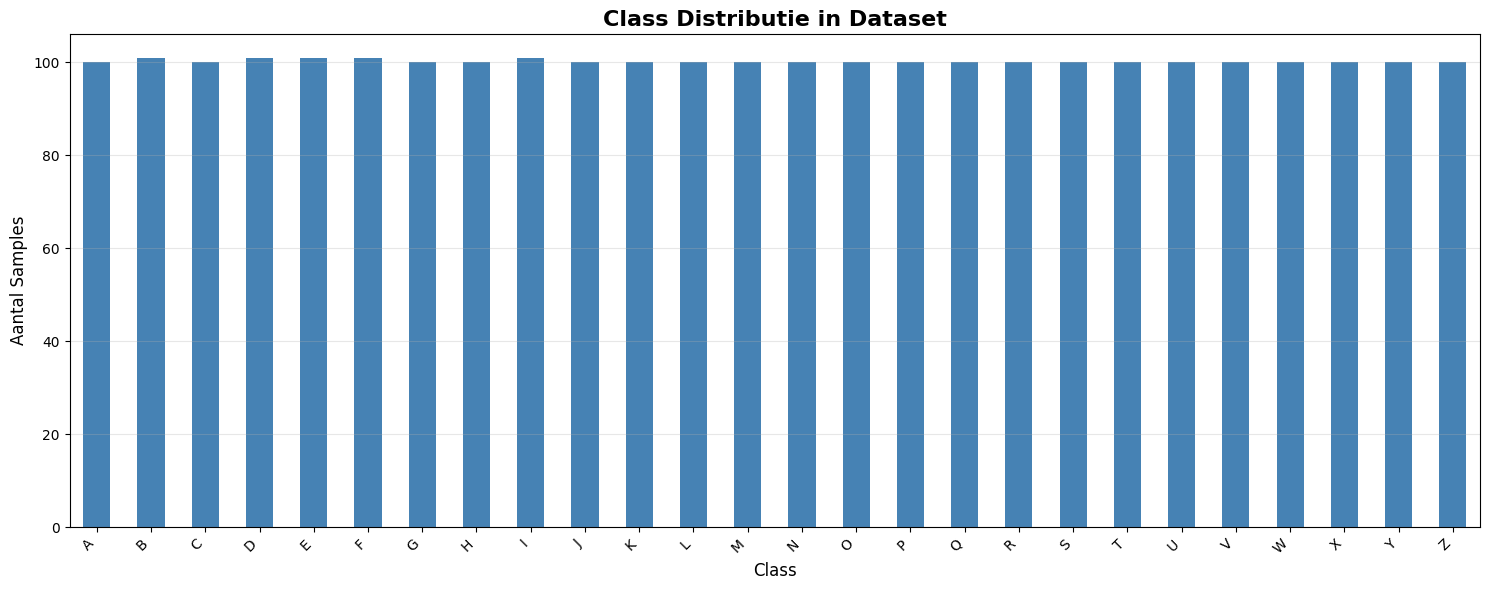


Totaal aantal samples: 2605
Gemiddeld aantal samples per class: 100.2
Min samples: 100, Max samples: 101


In [89]:
# Lees de originele JSONL dataset om per-class counts te berekenen
df = pd.read_json(HAND_LANDMARKS_JSON, lines=True)
class_counts = df['class'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
class_counts.plot(kind='bar', color='steelblue')
plt.title('Class Distributie in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Aantal Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotaal aantal samples: {len(df)}")
print(f"Gemiddeld aantal samples per class: {class_counts.mean():.1f}")
print(f"Min samples: {class_counts.min()}, Max samples: {class_counts.max()}")

In [90]:
in_dim = 63  # 21 landmarks * 3 coordinates
num_classes = len(classes)
model = create_model(num_classes, in_dim)

# Probeer opgeslagen gewichten te laden als aanwezig
weights_path = os.path.join(MODEL_DIR, 'vgt_model.pth')
if os.path.exists(weights_path):
    try:
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        print(f"Loaded weights from {weights_path}")
    except Exception as e:
        print(f"Failed loading weights from {weights_path}: {e}")
else:
    print(f"No saved weights at {weights_path}")

# Toon model en parameter tellen
print("\nModel architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotaal aantal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Input dimensie: {in_dim}")
print(f"Output classes: {num_classes}")
print(f"Device: {DEVICE}")


Loaded weights from /root/SmartGlasses/notebooks/package/smart_gestures/alphabet/vgt_model/models/vgt_model.pth

Model architecture:
Sequential(
  (0): Linear(in_features=63, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=256, out_features=26, bias=True)
)

Totaal aantal parameters: 435,994
Trainable parameters: 435,994
Input dimensie: 63
Output classes: 26
Device: cuda


In [91]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs.view(inputs.size(0), -1))
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Bereken accuracy
accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 99.42%


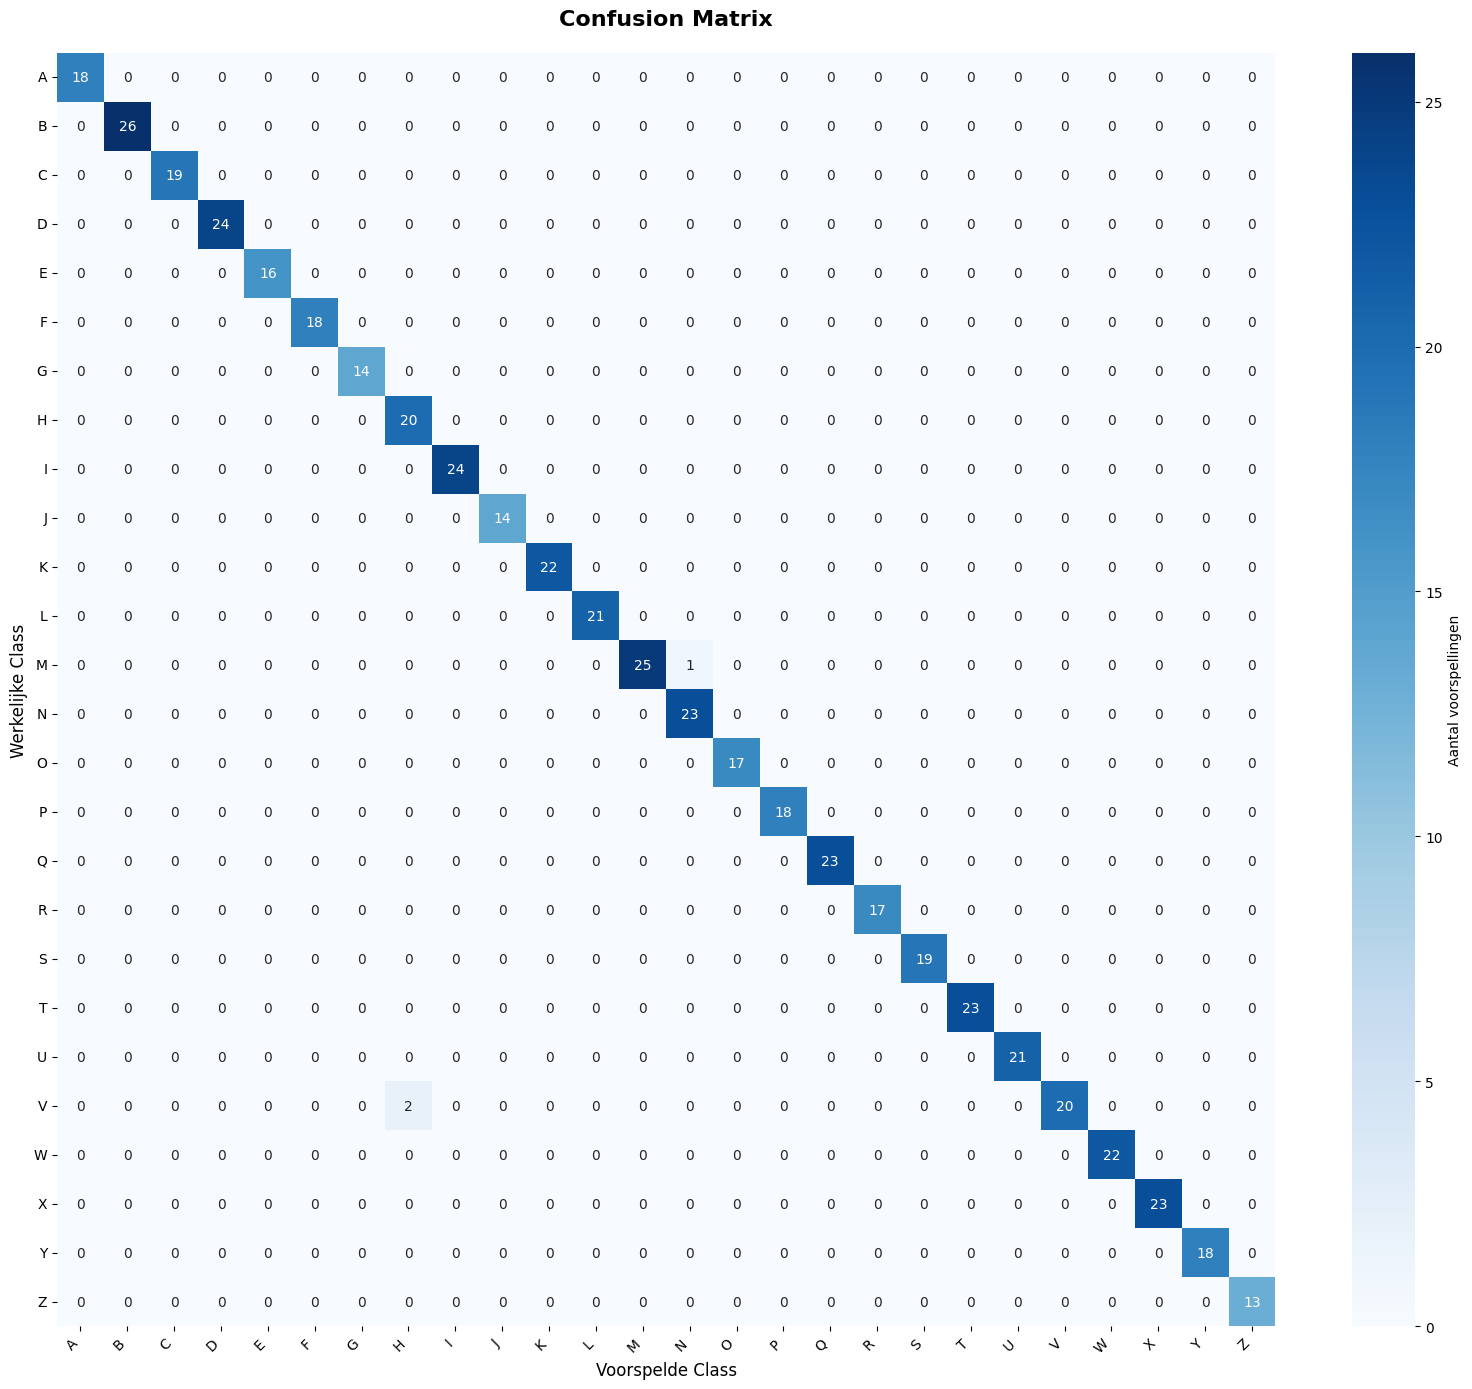

In [92]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Aantal voorspellingen'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Werkelijke Class', fontsize=12)
plt.xlabel('Voorspelde Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [93]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(all_labels, all_preds, target_names=classes, digits=3))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A      1.000     1.000     1.000        18
           B      1.000     1.000     1.000        26
           C      1.000     1.000     1.000        19
           D      1.000     1.000     1.000        24
           E      1.000     1.000     1.000        16
           F      1.000     1.000     1.000        18
           G      1.000     1.000     1.000        14
           H      0.909     1.000     0.952        20
           I      1.000     1.000     1.000        24
           J      1.000     1.000     1.000        14
           K      1.000     1.000     1.000        22
           L      1.000     1.000     1.000        21
           M      1.000     0.962     0.980        26
           N      0.958     1.000     0.979        23
           O      1.000     1.000     1.000        17
           P      1.000     1.000     1.000        18
           Q      1.000     1.000     1.000        23
    

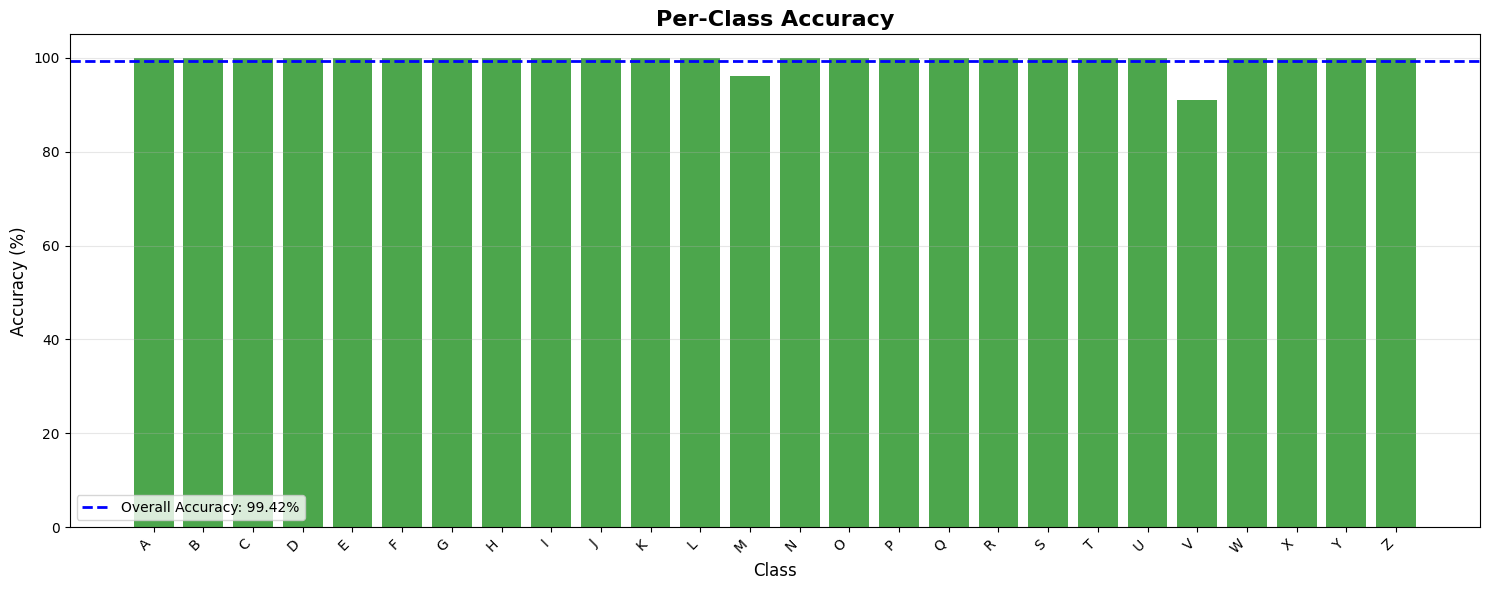


Classes met laagste accuracy:
  V: 90.91%
  M: 96.15%
  X: 100.00%
  W: 100.00%
  U: 100.00%


In [94]:
# Bereken per-class accuracy
per_class_accuracy = []
for i in range(len(classes)):
    mask = all_labels == i
    if mask.sum() > 0:
        acc = 100 * (all_preds[mask] == all_labels[mask]).sum() / mask.sum()
        per_class_accuracy.append(acc)
    else:
        per_class_accuracy.append(0)

# Plot per-class accuracy
plt.figure(figsize=(15, 6))
colors = ['green' if acc >= 90 else 'orange' if acc >= 70 else 'red' for acc in per_class_accuracy]
plt.bar(classes, per_class_accuracy, color=colors, alpha=0.7)
plt.axhline(y=accuracy, color='blue', linestyle='--', label=f'Overall Accuracy: {accuracy:.2f}%', linewidth=2)
plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print classes met laagste accuracy
print("\nClasses met laagste accuracy:")
sorted_indices = np.argsort(per_class_accuracy)[:5]
for idx in sorted_indices:
    print(f"  {classes[idx]}: {per_class_accuracy[idx]:.2f}%")

/tmp/ipykernel_597940/1467936303.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_confidences, incorrect_confidences], labels=['Correct', 'Incorrect'])


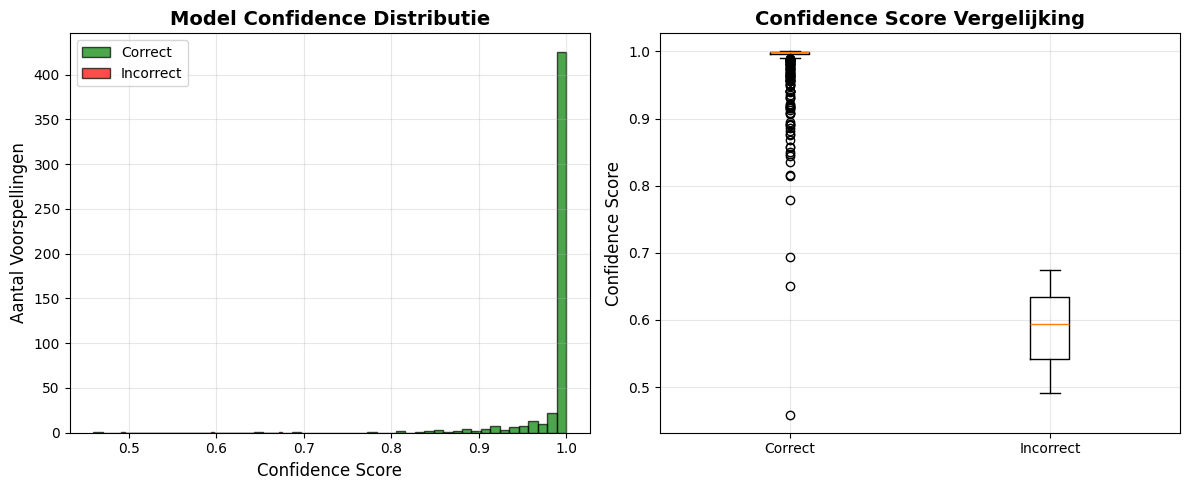


Gemiddelde confidence (correct): 0.9859
Gemiddelde confidence (incorrect): 0.5867


In [95]:
# Bereken confidence scores
all_confidences = []
correct_confidences = []
incorrect_confidences = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs.view(inputs.size(0), -1))
        probs = torch.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probs, 1)
        
        for conf, pred, label in zip(confidences.cpu().numpy(), 
                                     predicted.cpu().numpy(), 
                                     labels.cpu().numpy()):
            all_confidences.append(conf)
            if pred == label:
                correct_confidences.append(conf)
            else:
                incorrect_confidences.append(conf)

# Plot confidence distributie
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
plt.hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Aantal Voorspellingen', fontsize=12)
plt.title('Model Confidence Distributie', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([correct_confidences, incorrect_confidences], labels=['Correct', 'Incorrect'])
plt.ylabel('Confidence Score', fontsize=12)
plt.title('Confidence Score Vergelijking', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGemiddelde confidence (correct): {np.mean(correct_confidences):.4f}")
print(f"Gemiddelde confidence (incorrect): {np.mean(incorrect_confidences):.4f}")